<a href="https://colab.research.google.com/github/hidenoori/bri-hackathon-2021/blob/data-science/bri_hackathon_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

---

# BRI hackathon 2021 - People Analytics


> Machine learning memungkinkan para pembuat keputusan di departemen HR untuk memprediksikan performance karyawan dalam 1 tahun kedepan menggunakan data histori KPI yang dimiliki perusahaan. Dalam kategori People Analytics, peserta diminta untuk membangun machine learning model yang dapat memprediksi performance karyawan dengan akurat.




---

---





# 1. Preprocessing

## 1.1 Import Libraries & Datasets

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 7.4MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 481kB 14.6MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 112kB 21.2MB/s 
     |████████████████████████████████| 143kB 18.7MB/s 
  Created wheel for alembic: filename=alembic-1.5.5-py2.py3-none-any.whl size=156597 sha256=93ef6b59c374f8cf955a3ce22967afc9af85be3c6e30cdada1a57d50510c521d
  Stored in directory: /root/.cache/pip/wheels/74/3f/61/7de6e3cef766d2680a5d81b1a388286e640f6a681eb589d643
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=38e20c3dbef23e3c6f989663680d967191028bac04fdcd79feff04be1012056f
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=2

In [ ]:
# Function : Plot Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    from sklearn.model_selection import learning_curve
    """Generate a simple plot of the training & validation learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='roc_auc', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [ ]:
# Function : One Hot Encoder
def one_hot_encoding(df_data,cols_name, target, len_train) : ## cols_name must be formatted in list
    from sklearn.preprocessing import OneHotEncoder
    encoded_features_train = []
    encoded_features_test = []
    train_data = df_data.iloc[:len_train]
    test_data = df_data.iloc[len_train:]
    test_data.drop(target, axis=1, inplace=True)
    cnt = 0
    for feature in cols_name :
      encoded_feat = OneHotEncoder().fit_transform(df_data[feature].values.reshape(-1, 1)).toarray()
      n = df_data[feature].nunique()
      cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
      encoded_df = pd.DataFrame(encoded_feat, columns=cols)
      encoded_df.index = df_data.index
      encoded_df_tr = encoded_df.iloc[:len_train]
      encoded_df_ts = encoded_df.iloc[len_train:]
      encoded_features_train.append(encoded_df_tr)
      encoded_features_test.append(encoded_df_ts)
      cnt += 1
    train_X = pd.concat([train_data, *encoded_features_train[:cnt]], axis=1)
    test_X = pd.concat([test_data, *encoded_features_test[:cnt]], axis=1)
    return train_X, test_X

In [ ]:
# Import datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [ ]:
# Show train dataset
train.sample(5)

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Best Performance
10881,JG04,1.526434,PG03,1.526434,0.707107,RM_type_B,2,1989,Y,1,level_4,3.49,2011,6,4,2,1,10,0,50.60,0.0,0
6861,JG04,1.081665,PG03,1.081665,0.707107,RM_type_B,1,1988,Y,0,level_4,3.57,2010,6,3,4,1,4,5,63.74,0.0,0
7684,JG04,1.118034,PG03,1.118034,1.224745,RM_type_B,1,1992,N,0,level_4,0.00,2014,2,2,2,0,3,1,53.48,0.0,0
2970,JG04,1.414214,PG03,1.414214,0.707107,RM_type_A,2,1992,N,0,level_4,3.64,2014,3,2,2,0,5,3,51.61,0.0,0
9932,JG04,1.658312,PG03,1.658312,1.224745,RM_type_A,2,1986,Y,0,level_4,3.37,2009,6,4,4,0,3,0,116.80,3.0,0


In [ ]:
# Show test dataset
test.sample(5)

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
761,JG04,1.352775,PG03,1.352775,1.414214,RM_type_A,2,1991,Y,0,level_4,3.11,2013,4,3,4,1,7,0,48.89,0.0
5210,JG04,2.433105,PG04,1.581139,0.707107,RM_type_A,1,1978,Y,2,level_4,0.00,2001,16,10,9,0,3,0,88.27,1.0
4573,JG05,1.526434,PG06,0.000000,0.707107,RM_type_A,2,1978,Y,2,level_4,3.43,2002,15,10,9,2,6,0,69.95,0.0
1995,JG04,1.153256,PG03,1.153256,1.224745,RM_type_A,2,1990,Y,0,level_4,3.00,2012,3,2,2,0,2,0,13.00,0.0
3999,JG04,2.828427,PG04,2.121320,0.707107,RM_type_A,2,1980,Y,0,level_4,3.43,2003,15,6,7,0,3,0,107.49,3.0


In [ ]:
# Show sample dataset
sample.head(5)

,index,Best Performance
0,0,0.131028
1,1,0.379354
2,2,0.031798
3,3,0.285220
4,4,0.848732


In [ ]:
# Show size of train & test data
train.shape, test.shape

((11153, 22), (6000, 21))

In [ ]:
train_len = len(train) # Length of train data

## 1.2 Treat missing values

In [ ]:
# Check missing values on train data
mv = train.isnull().sum() != 0
mv_train = train.isnull().sum()[mv==True]
mv_train

Last_achievement_%                       1
Achievement_above_100%_during3quartal    1
dtype: int64

In [ ]:
# Check missing values on test data
mv = test.isnull().sum() != 0
mv_test = test.isnull().sum()[mv==True]
mv_test

Series([], dtype: int64)

In [ ]:
# Treat missing values on train data
## Last_achievement_%
train['Last_achievement_%'].nunique(), train['Last_achievement_%'].dtypes

(6104, dtype('float64'))

In [ ]:
train['Last_achievement_%'].fillna(train['Last_achievement_%'].median(),inplace=True)

In [ ]:
## Achievement_above_100%_during3quartal
train['Achievement_above_100%_during3quartal'].nunique(), train['Achievement_above_100%_during3quartal'].dtypes

(4, dtype('float64'))

In [ ]:
train['Achievement_above_100%_during3quartal'].value_counts()

0.0    7597
3.0    1604
1.0    1141
2.0     810
Name: Achievement_above_100%_during3quartal, dtype: int64

In [ ]:
train['Achievement_above_100%_during3quartal'].fillna(0.0,inplace=True)

In [ ]:
# Check missing values again
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [ ]:
# Concatenate train & test data
df = train.append(test).reset_index(drop=True)
df.shape, train.shape, test.shape

((17153, 22), (11153, 22), (6000, 21))

## 1.3 GPA

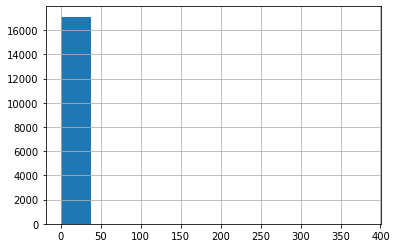

In [ ]:
# Show data distribution
df.GPA.hist(bins=10)
plt.show()

In [ ]:
# Check variance & maks or min of GPA feature
print("Variance of GPA feature : {}".format(df.GPA.var()))
print("Maximum value of GPA feature : {}".format(df.GPA.max()))
print("Minimum value of GPA feature : {}".format(df.GPA.min()))

Variance of GPA feature : 189.89388785882528
Maximum value of GPA feature : 381.0
Minimum value of GPA feature : 0.0


In [ ]:
# Check GPA value more than 4.0
train_gpa_4 = train[train.GPA > 4.0].GPA.count()
test_gpa_4 = test[test.GPA > 4.0].GPA.count()
train_gpa_4, test_gpa_4

(52, 31)

In [ ]:
df[df.GPA == 0].GPA.count(), len(df)

(3313, 17153)

In [ ]:
# Education_level
df.Education_level.unique()

array(['level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5'],
      dtype=object)

In [ ]:
df_edu0 = df[(df.Education_level == "level_0") & (df.GPA == 0)].GPA
df_edu1 = df[(df.Education_level == "level_1") & (df.GPA == 0)].GPA
df_edu2 = df[(df.Education_level == "level_2") & (df.GPA == 0)].GPA
df_edu3 = df[(df.Education_level == "level_3") & (df.GPA == 0)].GPA
df_edu4 = df[(df.Education_level == "level_4") & (df.GPA == 0)].GPA
df_edu5 = df[(df.Education_level == "level_5") & (df.GPA == 0)].GPA

In [ ]:
df_edu1.count(), df[df.Education_level == "level_1"].GPA.count()
## Banyaknya nilai GPA yg nol pada education level_1 adalah 161 dari 215

(161, 215)

In [ ]:
df_edu2.count(), df[df.Education_level == "level_2"].GPA.count()
## Banyaknya nilai GPA yg nol pada education level_2 adalah 3 dari 6

(3, 6)

In [ ]:
df_edu3.count(), df[df.Education_level == "level_3"].GPA.count()
## Banyaknya nilai GPA yg nol pada education level_3 adalah 496 dari 2687

(496, 2687)

In [ ]:
df_edu4.count(), df[df.Education_level == "level_4"].GPA.count()
## Banyaknya nilai GPA yg nol pada education level_4 adalah 2646 dari 14172

(2646, 14172)

In [ ]:
df_edu5.count(), df[df.Education_level == "level_5"].GPA.count()
## Banyaknya nilai GPA yg nol pada education level_5 adalah 7 dari 71

(7, 71)

In [ ]:
# Berdasarkan informasi yg diperoleh
## level_0 : intern
## level_1 : SLTA
## level_2 : D1
## level_3 : D3
## level_4 : S1
## level_5 : S2
### Mustahil bagi employee bisa keterima kerja kalau GPA nya nol, sehingga kemungkinan besar GPA yg nol itu "missing value"
### Karena level_1 dominan dengan GPA nol & GPA khusus buat multistrata, maka utk level_1 ganti semua nilainya dengan nol

In [ ]:
# Replace all values of level_1 with 0
for i in range(0,len(df)) :
  if (((df['GPA'][i] != 0) | (df['GPA'][i] > 4.0)) & (df['Education_level'][i] == 'level_1')) :
    df['GPA'][i] = 0
df[df.Education_level == 'level_1'].GPA.unique()

array([0.])

In [ ]:
# Replace zero values in level_3 with median
med_3 = df[df.Education_level == 'level_3'].GPA.median()
for i in range(0,len(df)) :
  if (((df['GPA'][i] == 0) | (df['GPA'][i] > 4.0)) & (df['Education_level'][i] == 'level_3')) :
    df['GPA'][i] = med_3
df[df.Education_level == 'level_3'].GPA.unique()

array([2.83, 2.95, 3.02, 3.14, 3.07, 3.01, 3.32, 3.27, 3.08, 3.  , 3.29,
       3.24, 3.3 , 3.53, 3.04, 3.38, 3.19, 2.92, 3.13, 3.21, 2.9 , 3.11,
       3.03, 2.93, 2.91, 3.12, 2.85, 2.82, 3.05, 3.1 , 3.23, 3.18, 3.26,
       2.81, 2.94, 3.09, 2.57, 2.87, 2.89, 3.46, 3.52, 2.74, 2.79, 3.78,
       3.75, 2.71, 3.39, 3.16, 2.77, 3.15, 3.43, 3.33, 3.71, 2.96, 3.36,
       3.65, 3.25, 3.45, 3.56, 3.76, 3.85, 3.61, 3.47, 2.99, 3.67, 3.2 ,
       3.59, 2.76, 3.69, 2.98, 2.88, 2.73, 3.66, 2.67, 2.53, 3.5 , 2.78,
       2.8 , 3.06, 3.7 , 3.28, 2.97, 3.8 , 2.75, 2.54, 2.55, 3.41, 3.31,
       2.7 , 2.69, 2.63, 3.82, 2.51, 3.58, 3.55, 3.37, 2.66, 3.63, 3.51,
       3.35, 2.84, 2.86, 3.77, 3.34, 3.49, 2.72, 2.62, 3.73, 2.5 , 2.  ,
       3.54, 3.6 , 3.17, 3.57, 2.56, 3.44, 3.74, 3.42, 3.68, 3.4 , 3.62,
       3.64, 3.22, 2.64, 2.68, 2.65, 2.59, 3.79, 3.97, 2.37, 3.48, 2.6 ,
       2.45, 2.61, 3.81, 3.86, 3.83, 3.89, 2.58, 3.91, 3.84, 3.72, 3.87])

In [ ]:
# Replace zero values in level_4 with median
med_4 = df[df.Education_level == 'level_4'].GPA.median()
for i in range(0,len(df)) :
  if (((df['GPA'][i] == 0) | (df['GPA'][i] > 4.0)) & (df['Education_level'][i] == 'level_4')) :
    df['GPA'][i] = med_4
df[df.Education_level == 'level_4'].GPA.unique()

array([3.09, 2.89, 3.13, 2.8 , 2.76, 3.  , 3.25, 3.56, 3.62, 3.18, 3.52,
       2.93, 2.92, 3.27, 3.36, 3.38, 3.45, 3.54, 3.08, 3.16, 3.03, 3.19,
       3.32, 3.07, 2.86, 3.2 , 3.15, 2.91, 3.44, 3.3 , 3.93, 3.42, 3.12,
       3.04, 3.29, 3.51, 3.26, 2.96, 3.39, 3.46, 3.22, 3.47, 2.95, 3.55,
       3.01, 3.4 , 2.94, 3.17, 2.97, 3.35, 3.34, 3.43, 3.1 , 3.11, 3.02,
       3.48, 3.21, 2.78, 3.37, 3.05, 3.31, 2.75, 2.88, 2.99, 3.06, 3.5 ,
       3.23, 2.9 , 3.59, 2.09, 3.49, 3.33, 2.65, 3.24, 3.14, 3.66, 2.74,
       3.78, 3.28, 3.75, 2.87, 3.92, 2.83, 3.57, 2.84, 2.85, 3.41, 3.71,
       2.82, 2.25, 3.89, 2.42, 3.67, 3.61, 2.72, 3.77, 3.91, 2.98, 3.58,
       3.64, 3.85, 2.77, 3.65, 3.6 , 2.81, 2.6 , 2.5 , 3.63, 3.84, 2.71,
       3.76, 2.64, 2.79, 2.62, 3.69, 2.67, 3.72, 3.53, 3.8 , 2.7 , 3.7 ,
       3.73, 3.68, 2.43, 2.69, 2.68, 0.3 , 2.73, 3.82, 3.88, 3.81, 2.66,
       2.61, 3.83, 3.74, 2.32, 2.63, 2.18, 2.57, 2.1 , 3.86, 2.48, 2.33,
       2.05, 2.58, 3.79, 3.9 , 2.44, 2.31, 3.87, 2.

In [ ]:
# Replace zero values in level_5 with median
med_5 = df[df.Education_level == 'level_5'].GPA.median()
for i in range(0,len(df)) :
  if (((df['GPA'][i] == 0) | (df['GPA'][i] > 4.0)) & (df['Education_level'][i] == 'level_5')) :
    df['GPA'][i] = med_5
df[df.Education_level == 'level_5'].GPA.unique()

array([3.32, 3.49, 3.86, 3.34, 3.54, 3.46, 3.57, 3.23, 3.77, 3.35, 3.28,
       3.  , 3.64, 3.73, 3.63, 3.44, 3.66, 3.3 , 3.84, 3.51, 3.75, 3.55,
       3.19, 3.5 , 3.8 , 3.33, 3.27, 3.58, 3.48, 3.53, 3.14, 3.76, 3.56,
       3.62, 3.6 , 3.47, 2.97, 3.43, 3.69, 3.83, 3.1 , 3.37])

In [ ]:
# Split df into train & test
train = df.iloc[:train_len]
test = df.iloc[train_len:]
test.drop('Best Performance',axis=1,inplace=True)
train.shape, test.shape

((11153, 22), (6000, 21))

# 2. EDA

## 2.1 Overview

In [ ]:
# Show statistic descriptive on train data
train.describe()

,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Best Performance
count,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.000000,11153.00000,11153.000000
mean,1.433208,1.349218,1.034646,1.735587,1985.837084,0.995517,3.105090,2009.174124,6.277952,3.720165,3.505694,1.202726,3.664216,1.100152,72.234852,0.67901,0.146777
std,0.431086,0.324660,0.416723,0.441040,4.632214,0.881103,0.416452,4.117162,5.033553,2.399068,1.818028,2.575138,2.652648,2.714525,23.029389,1.10735,0.353899
min,0.000000,0.000000,0.000000,1.000000,1963.000000,0.000000,0.000000,1982.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.510000,0.00000,0.000000
25%,1.224745,1.224745,0.707107,1.000000,1985.000000,0.000000,3.010000,2008.000000,4.000000,2.000000,2.000000,0.000000,2.000000,0.000000,56.650000,0.00000,0.000000
50%,1.352775,1.352775,1.118034,2.000000,1987.000000,1.000000,3.090000,2010.000000,5.000000,3.000000,3.000000,0.000000,3.000000,0.000000,71.675000,0.00000,0.000000
75%,1.414214,1.385641,1.224745,2.000000,1989.000000,2.000000,3.260000,2012.000000,6.000000,4.000000,4.000000,1.000000,5.000000,1.000000,88.170000,1.00000,0.000000
max,2.958040,2.828427,2.677686,2.000000,1997.000000,7.000000,3.970000,2019.000000,36.000000,22.000000,15.000000,29.000000,21.000000,77.000000,130.000000,3.00000,1.000000


In [ ]:
# Show statistic descriptive on test data
test.describe()

,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.433120,1.347325,1.030270,1.729500,1985.969167,0.98500,3.114108,2009.226000,6.21850,3.695333,3.481500,1.137667,3.700667,1.167333,72.100687,0.684333
std,0.420971,0.316625,0.413334,0.444255,4.433940,0.86693,0.416271,3.975117,4.87111,2.338323,1.802738,2.504814,2.645354,3.434089,22.709260,1.109005
min,0.000000,0.000000,0.000000,1.000000,1963.000000,0.00000,0.000000,1984.000000,2.00000,1.000000,1.000000,0.000000,0.000000,0.000000,10.650000,0.000000
25%,1.224745,1.224745,0.707107,1.000000,1985.000000,0.00000,3.010000,2008.000000,4.00000,2.000000,2.000000,0.000000,2.000000,0.000000,56.487500,0.000000
50%,1.352775,1.352775,1.118034,2.000000,1987.000000,1.00000,3.090000,2010.000000,5.00000,3.000000,3.000000,0.000000,3.000000,0.000000,71.065000,0.000000
75%,1.414214,1.385641,1.224745,2.000000,1989.000000,2.00000,3.270000,2012.000000,6.00000,4.000000,4.000000,1.000000,5.000000,1.000000,88.150000,1.000000
max,2.915476,2.828427,2.738613,2.000000,1995.000000,4.00000,4.000000,2020.000000,35.00000,17.000000,14.000000,27.000000,21.000000,115.000000,130.000000,3.000000


In [ ]:
# Show train data info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153 entries, 0 to 11152
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              11153 non-null  object 
 1   job_duration_in_current_job_level      11153 non-null  float64
 2   person_level                           11153 non-null  object 
 3   job_duration_in_current_person_level   11153 non-null  float64
 4   job_duration_in_current_branch         11153 non-null  float64
 5   Employee_type                          11153 non-null  object 
 6   gender                                 11153 non-null  int64  
 7   age                                    11153 non-null  int64  
 8   marital_status_maried(Y/N)             11153 non-null  object 
 9   number_of_dependences                  11153 non-null  int64  
 10  Education_level                        11153 non-null  object 
 11  GP

## 2.2 Show target distribution

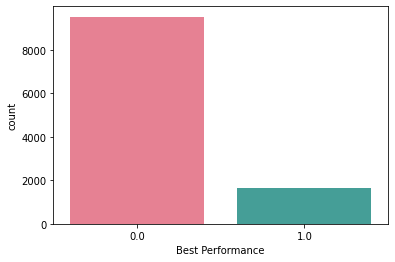

In [ ]:
sns.countplot(x='Best Performance', data=train, palette='husl')
plt.show()

In [ ]:
train['Best Performance'].value_counts(normalize=True)

0.0    0.853223
1.0    0.146777
Name: Best Performance, dtype: float64

In [ ]:
train['Best Performance'].value_counts()

0.0    9516
1.0    1637
Name: Best Performance, dtype: int64

## 2.3 Show data distributions (train data only)

In [ ]:
cols_cat = []
cols_num = []
for col in train.columns :
  if (train[col].dtypes != 'object') & (train[col].nunique() > 20) :
    cols_num.append(col)
  else :
    cols_cat.append(col)

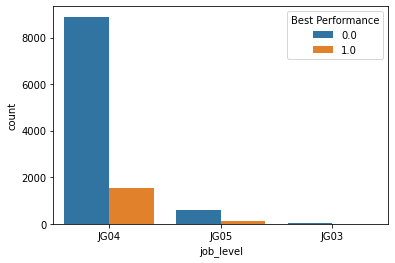

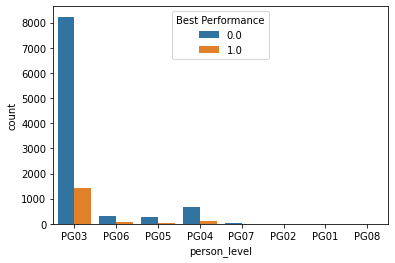

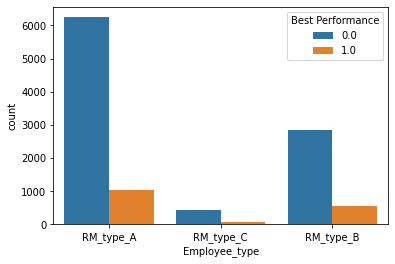

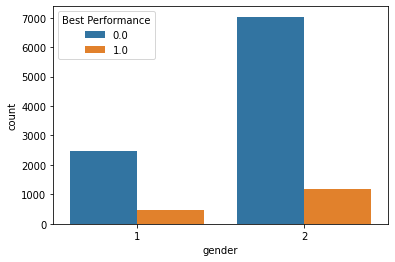

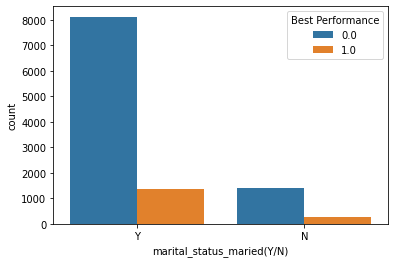

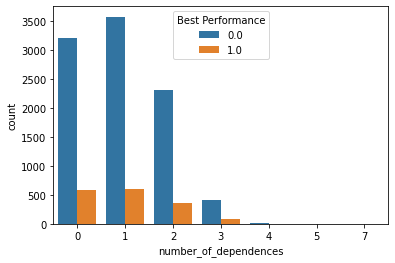

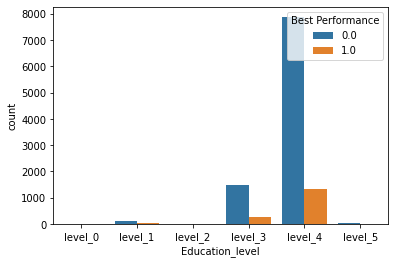

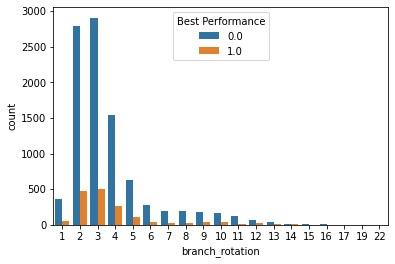

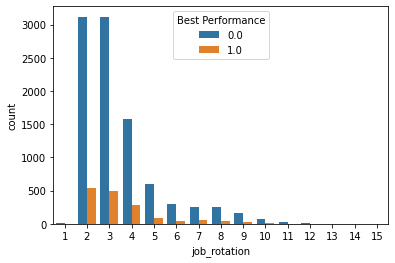

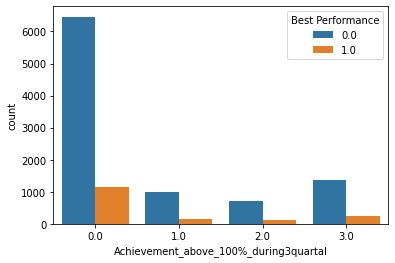

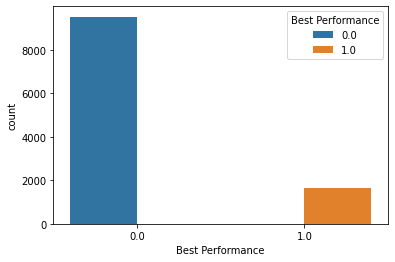

In [ ]:
# Show data distribution in categorical features
for col in cols_cat :
  sns.countplot(x=col, data=train, hue='Best Performance')
  plt.show()

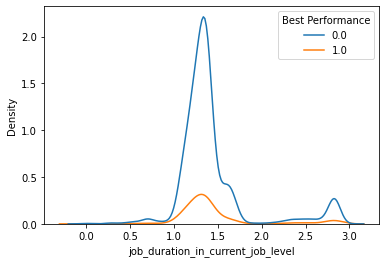

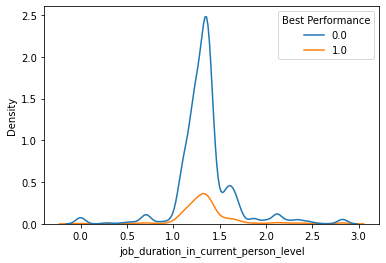

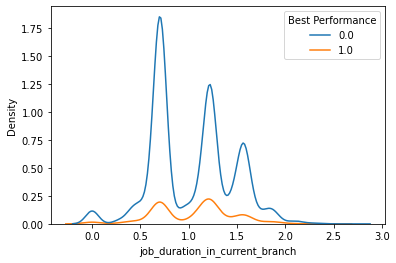

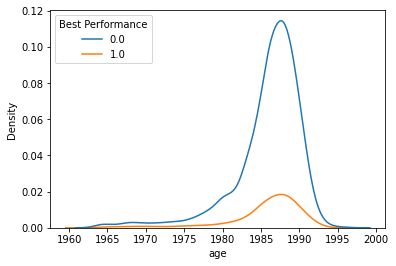

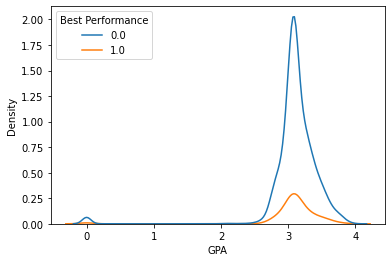

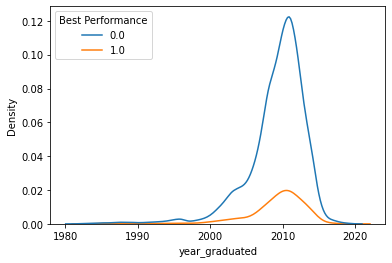

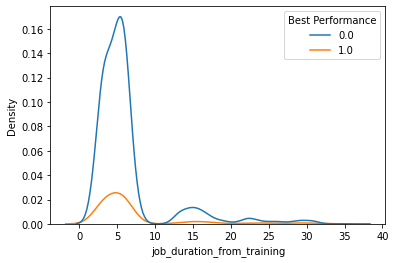

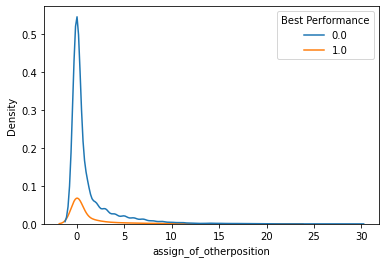

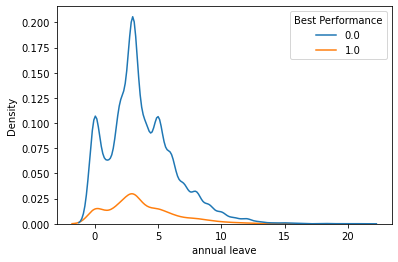

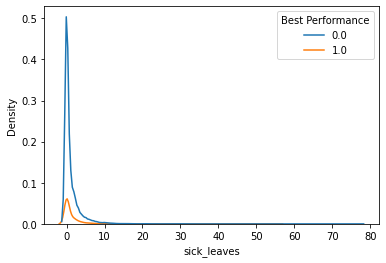

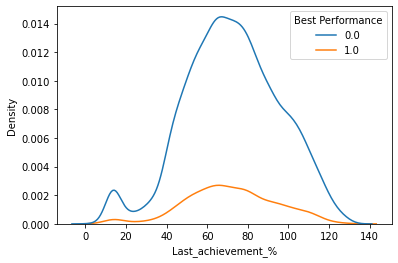

In [ ]:
# Show data distribution in numerical features
import math
for col in cols_num :
  sns.kdeplot(x=col, data=train, hue='Best Performance')
  plt.show()

## 2.4 Show data distributions (train + test data)

In [ ]:
# Append train & test data
df = train.append(test).reset_index(drop=True)
df.shape

(17153, 22)

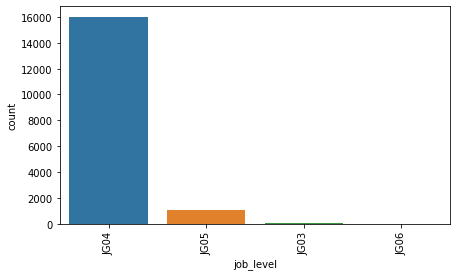

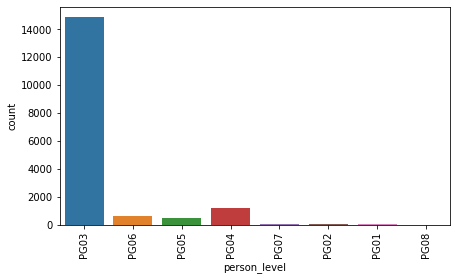

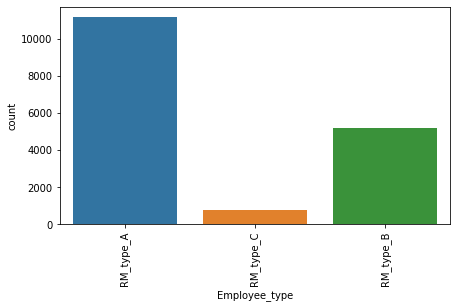

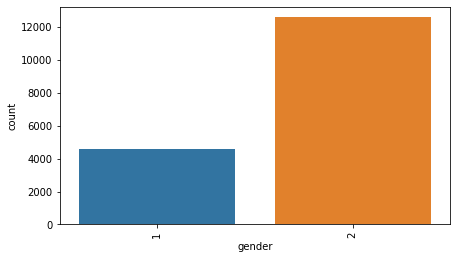

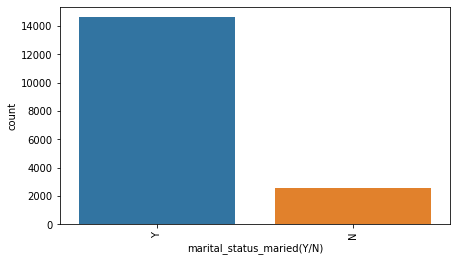

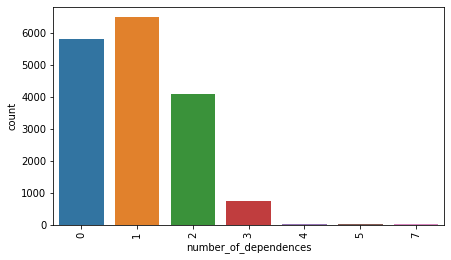

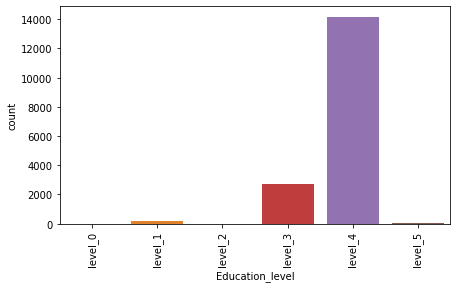

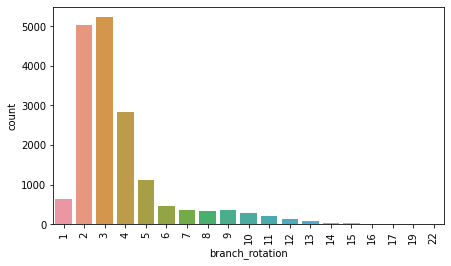

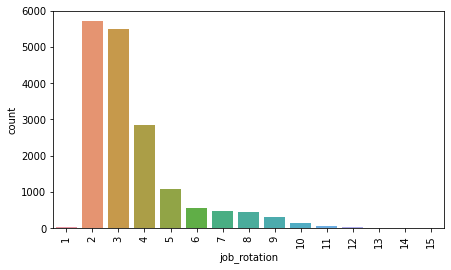

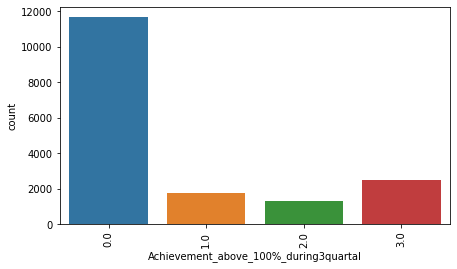

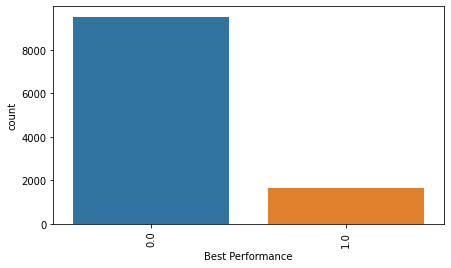

In [ ]:
# Show data distribution in categorical features
for col in cols_cat :
    plt.figure(figsize=(7,4))
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=90)
    plt.show()

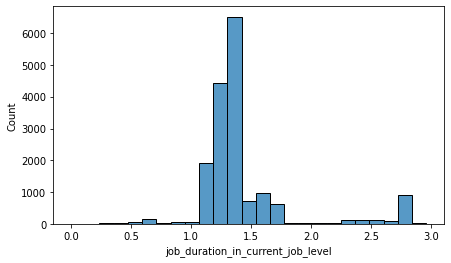

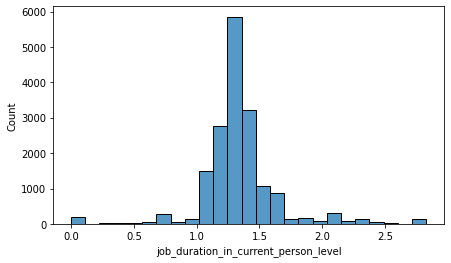

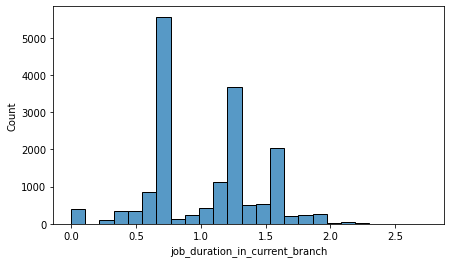

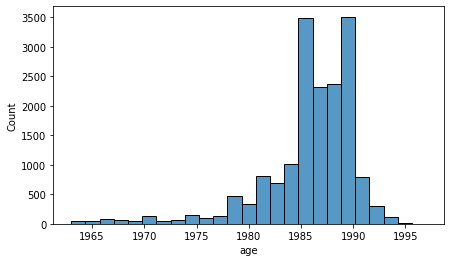

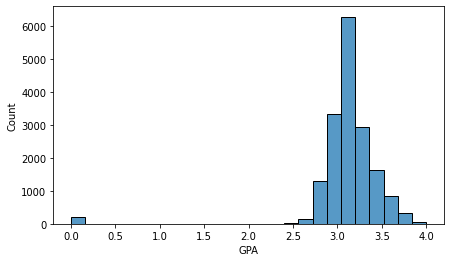

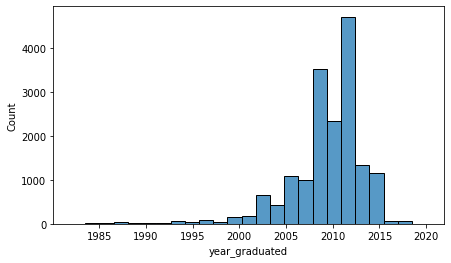

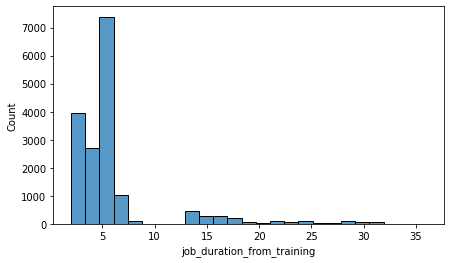

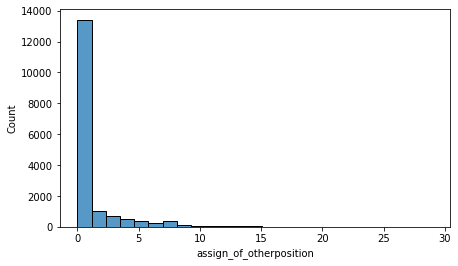

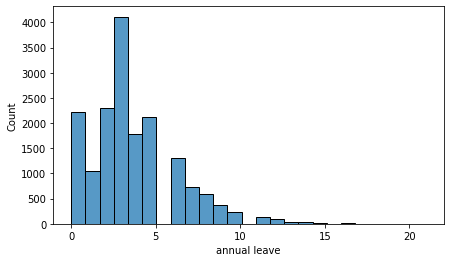

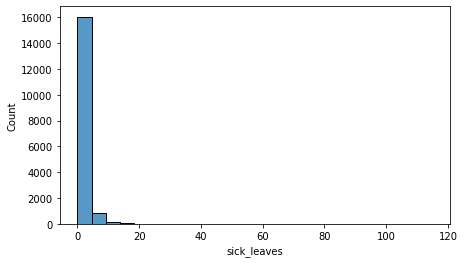

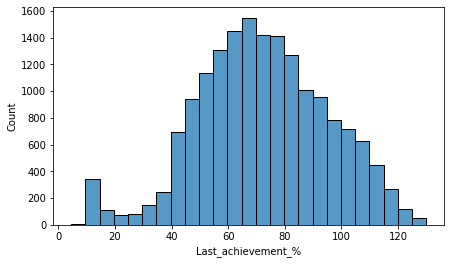

In [ ]:
# Show data distribution in numerical features
for col in cols_num :
  plt.figure(figsize=(7,4))
  sns.histplot(x=col, data=df, bins=25)
  plt.show()

## 2.5 Matrix Correlation

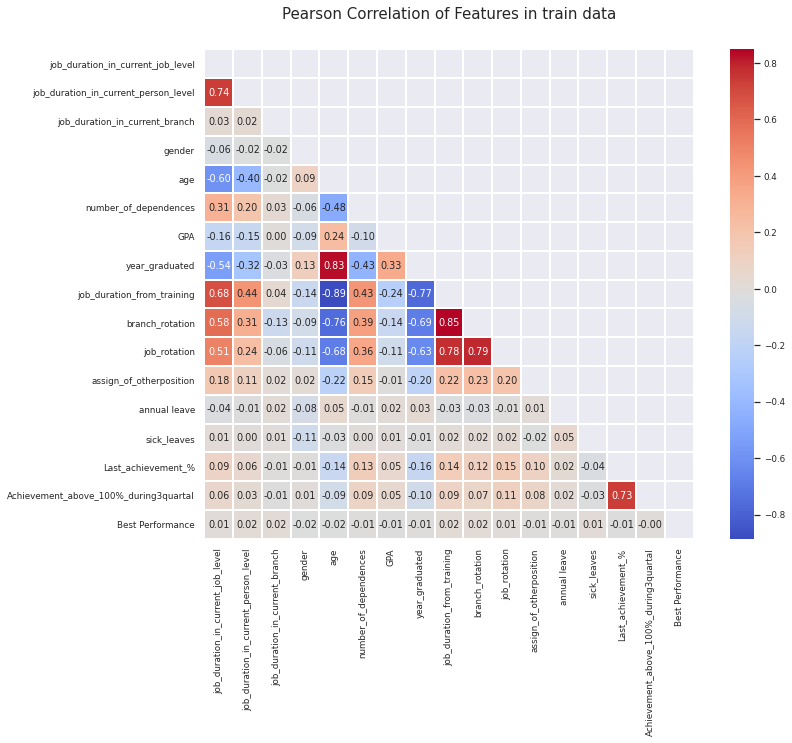

In [ ]:
# Create heatmap for train data
plt.figure(figsize=(13,9))
sns.set(font_scale=0.8)
plt.title('Pearson Correlation of Features in train data', y=1.05, size=15)
corr_train = train.corr()
mask = np.triu(corr_train.corr())
sns.heatmap(corr_train, square=True, linecolor='white', 
            annot=True, cmap='coolwarm', fmt='.2f', mask=mask,
            linewidths=1)
plt.show()

# 3. Feature Engineering

## 3.1 Feature Generation

In [ ]:
# Check missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

### 3.1.1 Year Graduated & Age

In [ ]:
# Age feature
df['Age_int'] = 2021 - df['age']
df['Age_int']

0        36
1        32
2        51
3        54
4        56
         ..
17148    33
17149    32
17150    30
17151    41
17152    34
Name: Age_int, Length: 17153, dtype: int64

In [ ]:
# Year graduated feature
df['year_grad_int'] = 2021 - df['year_graduated']
df['year_grad_int']

0        10
1        14
2        32
3        34
4        36
         ..
17148     6
17149    10
17150     8
17151    18
17152    13
Name: year_grad_int, Length: 17153, dtype: int64

In [ ]:
# Drop year graduated & age feature
df.drop(['year_graduated','age'],axis=1,inplace=True)

### 3.1.2 Sick leaves & Assign of otherposition

In [ ]:
# sick_leaves feature
df['has_sick_leaves'] = df.sick_leaves.apply(lambda x : 'no' if x == 0 else 'yes')
df['has_sick_leaves'].value_counts(normalize=True)

no     0.643677
yes    0.356323
Name: has_sick_leaves, dtype: float64

In [ ]:
# assign_of_otherposition feature
df['has_assign_of_otherposition'] = df.assign_of_otherposition.apply(lambda x : 'no' if x == 0 else 'yes')
df['has_assign_of_otherposition'].value_counts(normalize=True)

no     0.660526
yes    0.339474
Name: has_assign_of_otherposition, dtype: float64

### 3.1.3 Number of Dependences

In [ ]:
# Show data distribution
df.number_of_dependences.value_counts(ascending=False)

1    6482
0    5807
2    4095
3     742
4      22
5       4
7       1
Name: number_of_dependences, dtype: int64

In [ ]:
df['number_of_dependences'] = df.number_of_dependences.apply(lambda x : 'more three' if x > 3 else x)
df['number_of_dependences'] = df.number_of_dependences.replace(0, 'none')
df['number_of_dependences'] = df.number_of_dependences.replace(1, 'one')
df['number_of_dependences'] = df.number_of_dependences.replace(2, 'two')
df['number_of_dependences'] = df.number_of_dependences.replace(3, 'three')

In [ ]:
df.number_of_dependences.unique()

array(['one', 'none', 'two', 'three', 'more three'], dtype=object)

## 3.2 Feature Encoding

### 3.2.1 Binary Encoding

In [ ]:
obj_bin = []
for col in df.columns :
  if (df[col].dtypes == 'object') & (df[col].nunique() == 2):
    obj_bin.append(col)
obj_bin

['marital_status_maried(Y/N)',
 'has_sick_leaves',
 'has_assign_of_otherposition']

In [ ]:
df['has_sick_leaves'] = df['has_sick_leaves'].map({"yes":1,"no":0})
df['has_assign_of_otherposition'] = df['has_assign_of_otherposition'].map({"yes":1,"no":0})
df['marital_status_maried(Y/N)'] = df['marital_status_maried(Y/N)'].map({"Y":1,"N":0})

### 3.2.2 One Hot Encoding

In [ ]:
# Search categorical object features
obj_cols = []
for col in df.columns :
  if (df[col].dtypes == 'object') & (df[col].nunique() != 2):
    obj_cols.append(col)

In [ ]:
obj_cols

['job_level',
 'person_level',
 'Employee_type',
 'number_of_dependences',
 'Education_level']

In [ ]:
# Encoding dataset with One Hot Encoding
train_enc, test_enc = one_hot_encoding(df,obj_cols, "Best Performance", train_len)
train_enc.shape, test_enc.shape

((11153, 50), (6000, 49))

In [ ]:
# Drop Irrelevant Features
train_enc.drop(obj_cols,axis=1,inplace=True)
test_enc.drop(obj_cols,axis=1,inplace=True)
train_enc.isnull().sum().any(), test_enc.isnull().sum().any()

(False, False)

## 3.3 Feature Transformation

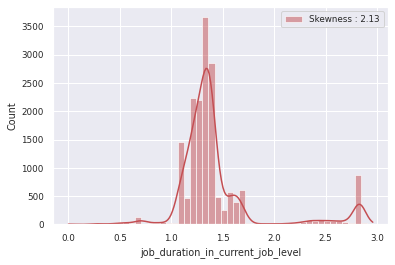

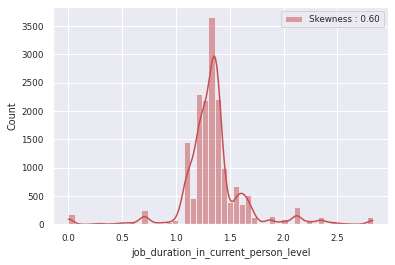

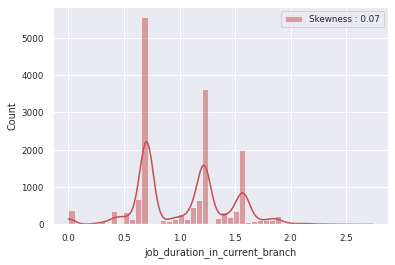

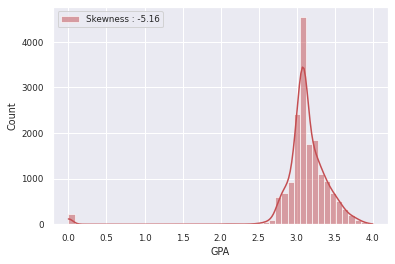

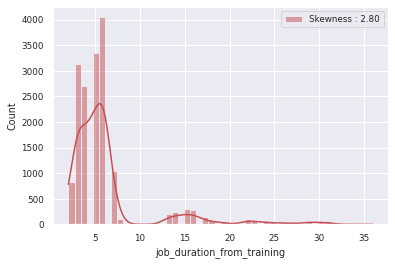

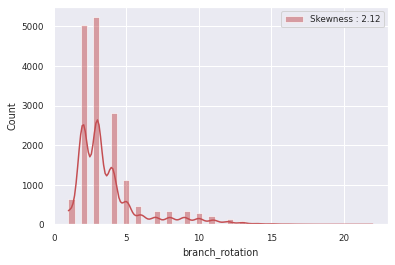

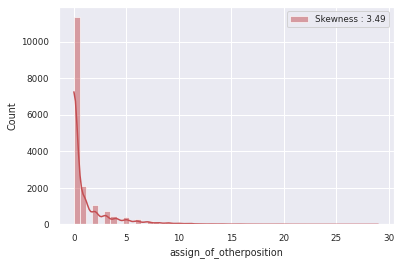

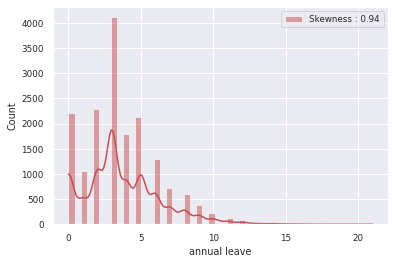

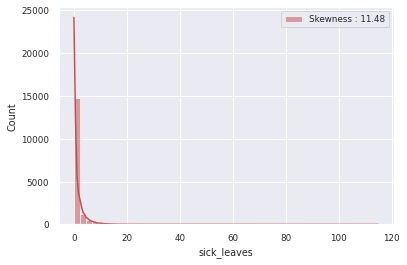

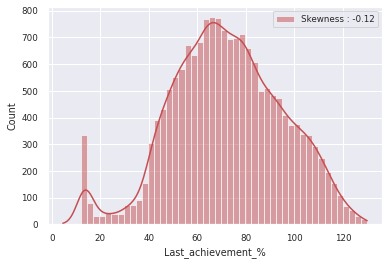

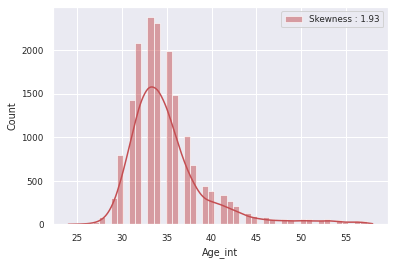

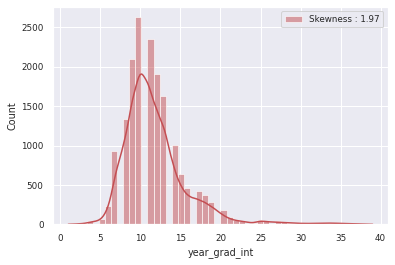

In [ ]:
# Show data distribution
for col in df.columns :
  if df[col].nunique() > 15 :
    g = sns.histplot(df[col], color="r", bins=50, kde=True, label="Skewness : %.2f"%(df[col].skew()))
    g = g.legend(loc="best")
    plt.show()

In [ ]:
# Search features for feature binning
cols_bin = []
for col in train_enc.columns : 
  if train_enc[col].nunique() > 15 :
    if (df[col].skew() > 2) | (df[col].skew() < -2) :
      cols_bin.append(col)

In [ ]:
# Feature Binning
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.pipeline import Pipeline
le = LabelEncoder()
discretizer = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans') 
train_enc[cols_bin] = discretizer.fit_transform(train_enc[cols_bin])
test_enc[cols_bin] = discretizer.transform(test_enc[cols_bin])

In [ ]:
# Label Encoding
for col in cols_bin :
  train_enc[col] = le.fit_transform(train_enc[col])
  test_enc[col] = le.transform(test_enc[col])

## 3.4 Feature Selection

In [ ]:
# Check missing values again
train_enc.isnull().sum().any(), test_enc.isnull().sum().any()

(False, False)

In [ ]:
# Split dataset into X, X_test, y
target = train_enc['Best Performance'].values
train_data = train_enc.drop('Best Performance',axis=1).values
test_data = test_enc.values

In [ ]:
train_data.shape, test_data.shape, target.shape

((11153, 44), (6000, 44), (11153,))

# 4. Modelling

> Balancing Techniques (Combination) :\
    - SMOTEENN\
    - SMOTETOMEK\
    - With pipeline(under-sampling, SMOTE)

> Balancing Techniques (Oversampling) :\
    - SMOTEBonderline\
    - ADASYN

> Balancing Techniques (Undersampling) :\
    - CondensedNearestNeighbors\
    - EditedNearestNeighbors\
    - AllKNN

> Model Machine Learning to used :\
    - XGboost\
    - RandomForestClassifier

In [ ]:
# Assign to new variable
X = train_data
y = target
X_test = test_data

In [ ]:
# Check size of data
X.shape, X_test.shape, y.shape

((11153, 44), (6000, 44), (11153,))

## 4.1 Find the best method to treat imbalanced data

In [ ]:
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

Random Forest(n_estimators = 700) ----> RandomOverSampler (0.5585511824421108)\
XGBoost(n_estimators=700) ----> BorderlineSMOTE (0.5646932206821932)\
AdaBoost (n_estimators=700) ----> BorderlineSMOTE (0.5631169267942236)

RandomForest(n_estimators=700) ----> SMOTEENN (0.5502066853949271)\
XGBoost(n_estimators=700) ----> SMOTETomek (0.5620037329095685)\
AdaBoost(n_estimators=700) ----> SMOTETomek (0.5646958737311569)

BalancedBaggingClassifier(n_estimators=1000) ---> 0.5750212377311513\
EasyEnsembleClassifier(n_estimators=1000) ---> 0.5728665614915999\
RUSBoostClassifier(n_estimators=1000) ---> 0.5227483854464432



## 4.2 Apply Method of treat imbalanced

### 4.2.1 Oversampling method

In [ ]:
# Random Forest Classifier
forest = RandomForestClassifier(random_state=0, n_estimators=5, n_jobs=-1, max_depth=3, max_features=0.8)
oversampler = RandomOverSampler(random_state=0)
pipe1 = Pipeline(steps = [('oversampler', oversampler), ('forest',forest)])
scores = cross_val_score(pipe1, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.5703252644021208, 0.015457497019837176)

In [ ]:
pipe1.fit(X,y)
yhat1 = pipe1.predict(X_test)
Counter(yhat1)

Counter({0.0: 3883, 1.0: 2117})

In [ ]:
# XGBClassifier
xgb = XGBClassifier(random_state=0, learning_rate=0.01, n_estimators=6, n_jobs=-1)
borderline = BorderlineSMOTE(random_state=0)
pipe2 = Pipeline(steps = [('borderline', borderline), ('xgboost',xgb)])
scores = cross_val_score(pipe2, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.5503408834809644, 0.017445975987391112)

In [ ]:
pipe2.fit(X,y)
yhat2 = pipe2.predict(X_test)
Counter(yhat2)

Counter({0.0: 3536, 1.0: 2464})

In [ ]:
# AdaBoost
ada = AdaBoostClassifier(random_state=0, learning_rate=0.01, n_estimators=100)
borderline = BorderlineSMOTE(random_state=0)
pipe3 = Pipeline(steps = [('borderline', borderline), ('ada',ada)])
scores = cross_val_score(pipe3, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.543898076766781, 0.012295759253652543)

In [ ]:
pipe3.fit(X,y)
yhat3 = pipe3.predict(X_test)
Counter(yhat3)

Counter({0.0: 3246, 1.0: 2754})

### 4.2.2 Combine method

In [ ]:
# Random Forest Classifier
forest = RandomForestClassifier(random_state=0, n_estimators=100, n_jobs=-1, max_depth=7, max_features=0.8)
smoteen = SMOTEENN(random_state=0)
pipe4 = Pipeline(steps = [('smoteen', smoteen), ('forest',forest)])
scores = cross_val_score(pipe4, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.5592263155375767, 0.019526199348140188)

In [ ]:
pipe4.fit(X,y)
yhat4 = pipe4.predict(X_test)
Counter(yhat4)

Counter({0.0: 3843, 1.0: 2157})

In [ ]:
# XGBoost
xgb = XGBClassifier(random_state=0, learning_rate=0.01, n_estimators=6, n_jobs=-1)
smotetomek = SMOTETomek(random_state=0)
pipe5 = Pipeline(steps = [('smotetomek', smotetomek), ('xgboost',xgb)])
scores = cross_val_score(pipe5, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.5569097090115428, 0.013121053128140549)

In [ ]:
pipe5.fit(X,y)
yhat5 = pipe5.predict(X_test)
Counter(yhat5)

Counter({0.0: 3536, 1.0: 2464})

### 4.2.3 Ensemble Modelling (Imblearn)

In [ ]:
# Balanced Bagging Classifier
from imblearn.ensemble import BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(random_state=0, base_estimator=AdaBoostClassifier(random_state=0, n_estimators=1000, learning_rate=1.0))
pipe6 = Pipeline(steps = [('bbc',bbc)])
scores = cross_val_score(pipe6, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.5548057997165031, 0.014917258873508341)

In [ ]:
pipe6.fit(X,y)
yhat6 = pipe6.predict(X_test)
Counter(yhat6)

Counter({0.0: 3513, 1.0: 2487})

In [ ]:
# Easy Ensemble Classifier
eec = EasyEnsembleClassifier(n_estimators=10, base_estimator=AdaBoostClassifier(random_state=0, n_estimators=1000, 
                                                                                learning_rate=1.0), 
                             n_jobs=-1, random_state=0)
pipe7 = Pipeline(steps = [('eec',eec)])
scores = cross_val_score(pipe7, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.5563261499923619, 0.012691213681473697)

In [ ]:
pipe7.fit(X,y)
yhat7 = pipe7.predict(X_test)
Counter(yhat7)

Counter({0.0: 3314, 1.0: 2686})

In [ ]:
# RUSBoostClassifier
rusb = RUSBoostClassifier(base_estimator=AdaBoostClassifier(random_state=0, n_estimators=1000, learning_rate=1.0),
                          random_state=0, n_estimators=100)
pipe8 = Pipeline(steps = [('rusb',rusb)])
scores = cross_val_score(pipe8, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
scores.mean(), scores.std()

(0.5577259786125573, 0.013236971421635981)

In [ ]:
pipe8.fit(X,y)
yhat8 = pipe8.predict(X_test)
Counter(yhat8)

Counter({0.0: 3246, 1.0: 2754})

In [ ]:
yhat = pipe7.predict_proba(X_test)[:,1]
sample["Best Performance"] = yhat
sample.to_csv("submission_MI_EEC.csv", index=False)

In [ ]:
yhat = pipe8.predict_proba(X_test)[:,1]
sample["Best Performance"] = yhat
sample.to_csv("submission_MI_RUS.csv", index=False)